In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dubins_planner import DubinsPath
from rrt_star import RRTStarDubins

In [3]:
obstacleList = [
    [-5.6749, 1.20558, 0.521155],
    [-3.42783, -2.3167, 0.620818],
    [2.07, 5.36304, 0.534224],
    [-2.02172, -3.82217, 0.462809],
    [1.09052, -0.990239, 0.644405],
    [-4, 6.92, 0.01],
    [-4, 6.92, 0.01],
    [-3.6, 6.92, 0.01],
    [-3.2, 6.92, 0.01],
    [-2.8, 6.92, 0.01],
    [-2.4, 6.92, 0.01],
    [-2, 6.92, 0.01],
    [-1.6, 6.92, 0.01],
    [-1.2, 6.92, 0.01],
    [-0.8, 6.92, 0.01],
    [-0.4, 6.92, 0.01],
    [0, 6.92, 0.01],
    [0.4, 6.92, 0.01],
    [0.8, 6.92, 0.01],
    [1.2, 6.92, 0.01],
    [1.6, 6.92, 0.01],
    [2, 6.92, 0.01],
    [2.4, 6.92, 0.01],
    [2.8, 6.92, 0.01],
    [3.2, 6.92, 0.01],
    [3.6, 6.92, 0.01],
    [4, 6.92, 0.01],
    [4.2, 6.574, 0.01],
    [4.4, 6.228, 0.01],
    [4.6, 5.882, 0.01],
    [4.8, 5.536, 0.01],
    [5, 5.19, 0.01],
    [5.2, 4.844, 0.01],
    [5.4, 4.498, 0.01],
    [5.6, 4.152, 0.01],
    [5.8, 3.806, 0.01],
    [6, 3.46, 0.01],
    [6.2, 3.114, 0.01],
    [6.4, 2.768, 0.01],
    [6.6, 2.422, 0.01],
    [6.8, 2.076, 0.01],
    [7, 1.73, 0.01],
    [7.2, 1.384, 0.01],
    [7.4, 1.038, 0.01],
    [7.6, 0.692, 0.01],
    [7.8, 0.346, 0.01],
    [8, 0, 0.01],
    [7.8, -0.346, 0.01],
    [7.6, -0.692, 0.01],
    [7.4, -1.038, 0.01],
    [7.2, -1.384, 0.01],
    [7, -1.73, 0.01],
    [6.8, -2.076, 0.01],
    [6.6, -2.422, 0.01],
    [6.4, -2.768, 0.01],
    [6.2, -3.114, 0.01],
    [6, -3.46, 0.01],
    [5.8, -3.806, 0.01],
    [5.6, -4.152, 0.01],
    [5.4, -4.498, 0.01],
    [5.2, -4.844, 0.01],
    [5, -5.19, 0.01],
    [4.8, -5.536, 0.01],
    [4.6, -5.882, 0.01],
    [4.4, -6.228, 0.01],
    [4.2, -6.574, 0.01],
    [4, -6.92, 0.01],
    [3.6, -6.92, 0.01],
    [3.2, -6.92, 0.01],
    [2.8, -6.92, 0.01],
    [2.4, -6.92, 0.01],
    [2, -6.92, 0.01],
    [1.6, -6.92, 0.01],
    [1.2, -6.92, 0.01],
    [0.8, -6.92, 0.01],
    [0.4, -6.92, 0.01],
    [0, -6.92, 0.01],
    [-0.4, -6.92, 0.01],
    [-0.8, -6.92, 0.01],
    [-1.2, -6.92, 0.01],
    [-1.6, -6.92, 0.01],
    [-2, -6.92, 0.01],
    [-2.4, -6.92, 0.01],
    [-2.8, -6.92, 0.01],
    [-3.2, -6.92, 0.01],
    [-3.6, -6.92, 0.01],
    [-4, -6.92, 0.01],
    [-4.2, -6.574, 0.01],
    [-4.4, -6.228, 0.01],
    [-4.6, -5.882, 0.01],
    [-4.8, -5.536, 0.01],
    [-5, -5.19, 0.01],
    [-5.2, -4.844, 0.01],
    [-5.4, -4.498, 0.01],
    [-5.6, -4.152, 0.01],
    [-5.8, -3.806, 0.01],
    [-6, -3.46, 0.01],
    [-6.2, -3.114, 0.01],
    [-6.4, -2.768, 0.01],
    [-6.6, -2.422, 0.01],
    [-6.8, -2.076, 0.01],
    [-7, -1.73, 0.01],
    [-7.2, -1.384, 0.01],
    [-7.4, -1.038, 0.01],
    [-7.6, -0.692, 0.01],
    [-7.8, -0.346, 0.01],
    [-8, 0, 0.01],
    [-7.8, 0.346, 0.01],
    [-7.6, 0.692, 0.01], [-7.4, 1.038, 0.01],
    [-7.2, 1.384, 0.01],
    [-7, 1.73, 0.01],
    [-6.8, 2.076, 0.01],
    [-6.6, 2.422, 0.01],
    [-6.4, 2.768, 0.01],
    [-6.2, 3.114, 0.01],
    [-6, 3.46, 0.01],
    [-5.8, 3.806, 0.01],
    [-5.6, 4.152, 0.01],
    [-5.4, 4.498, 0.01],
    [-5.2, 4.844, 0.01],
    [-5, 5.19, 0.01],
    [-4.8, 5.536, 0.01],
    [-4.6, 5.882, 0.01],
    [-4.4, 6.228, 0.01],
    [-4.2, 6.574, 0.01],
]

In [4]:
# np.random.seed(13)
obstacleList = np.array(obstacleList)

# Set Initial parameters
start = [0, -1, np.deg2rad(90)]
goal = [0.18, -6.42, np.deg2rad(-90)]

rnd_min = -9
rnd_max = 9

rrtstar_dubins = RRTStarDubins(start, goal, rand_area=[
                               rnd_min, rnd_max], obstacle_list=obstacleList, robot_radius=0.353)

In [5]:
# %%time
path = rrtstar_dubins.planning(search_until_max_iter=False)

Iter: 0 , number of nodes: 1
Iter: 1 , number of nodes: 1
Iter: 2 , number of nodes: 2
Iter: 3 , number of nodes: 2
Iter: 4 , number of nodes: 2
Iter: 5 , number of nodes: 2
Iter: 6 , number of nodes: 2
Iter: 7 , number of nodes: 2
Iter: 8 , number of nodes: 2
Iter: 9 , number of nodes: 2
Iter: 10 , number of nodes: 3
Iter: 11 , number of nodes: 4


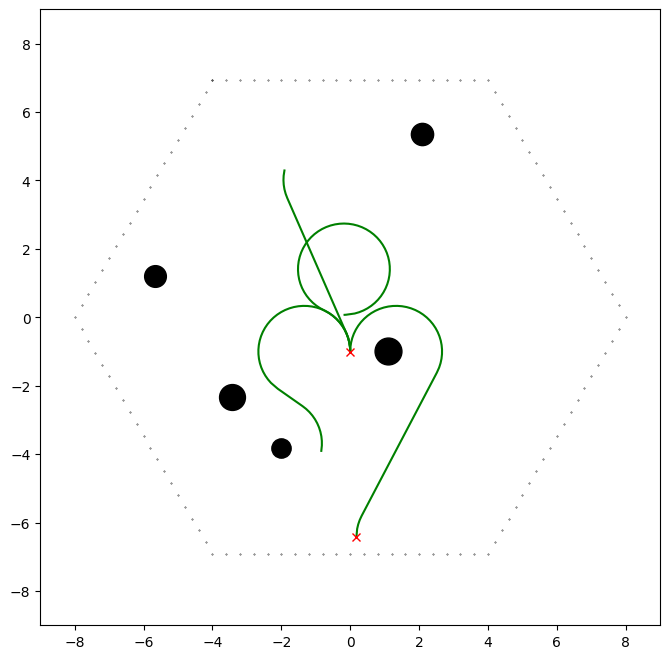

In [6]:
plt.figure(figsize=(8, 8))
rrtstar_dubins.draw_graph()
# plt.figure(figsize=(8, 8))
# plt.xlim(-2, 17)
# plt.ylim(-2, 17)
# plt.plot([x for (x, y) in path], [y for (x, y) in path], '-r')
# # plt.scatter([x for (x, y) in path], [y for (x, y) in path])
# plt.grid(True)
# plt.show()

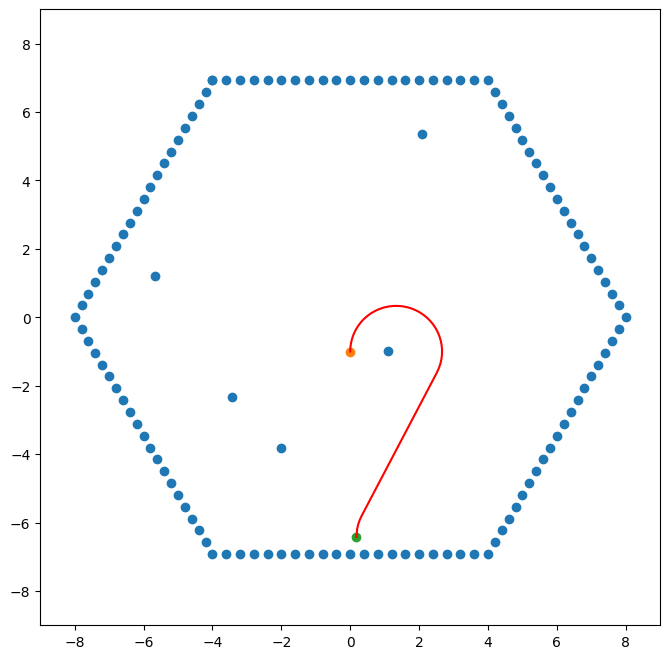

In [7]:
plt.figure(figsize=(8, 8))
plt.xlim(-9, 9)
plt.ylim(-9, 9)
plt.scatter(obstacleList[...,0], obstacleList[...,1])
plt.scatter(start[0], start[1])
plt.scatter(goal[0], goal[1])
plt.plot([x for (x, y) in path], [y for (x, y) in path], color="red")
plt.show()

In [8]:
path = np.array(path)

In [9]:
path

array([[ 1.80000000e-01, -6.42000000e+00],
       [ 2.01752719e-01, -6.18013739e+00],
       [ 2.32251463e-01, -6.05039613e+00],
       [ 2.75550353e-01, -5.92434783e+00],
       [ 3.31216762e-01, -5.80325192e+00],
       [ 4.18506446e-01, -5.63594442e+00],
       [ 4.80181253e-01, -5.51773276e+00],
       [ 5.41856061e-01, -5.39952110e+00],
       [ 6.03530869e-01, -5.28130945e+00],
       [ 6.65205676e-01, -5.16309779e+00],
       [ 7.26880484e-01, -5.04488613e+00],
       [ 7.88555292e-01, -4.92667448e+00],
       [ 8.50230099e-01, -4.80846282e+00],
       [ 9.11904907e-01, -4.69025116e+00],
       [ 9.73579714e-01, -4.57203950e+00],
       [ 1.03525452e+00, -4.45382785e+00],
       [ 1.09692933e+00, -4.33561619e+00],
       [ 1.15860414e+00, -4.21740453e+00],
       [ 1.22027894e+00, -4.09919288e+00],
       [ 1.28195375e+00, -3.98098122e+00],
       [ 1.34362856e+00, -3.86276956e+00],
       [ 1.40530337e+00, -3.74455790e+00],
       [ 1.46697818e+00, -3.62634625e+00],
       [ 1.

In [13]:
for i in range(len(path)-1):
    print(np.linalg.norm(path[i]-path[i+1]))

0.24084694651072813
0.1332777847218089
0.13327778472180882
0.1332777847218087
0.18870953907780808
0.13333333333333383
0.13333333333333391
0.1333333333333328
0.13333333333333305
0.1333333333333338
0.13333333333333303
0.1333333333333337
0.13333333333333375
0.13333333333333391
0.13333333333333217
0.1333333333333337
0.13333333333333391
0.13333333333333292
0.1333333333333333
0.1333333333333333
0.13333333333333341
0.1333333333333338
0.13333333333333341
0.1333333333333333
0.13333333333333341
0.1333333333333338
0.13333333333333341
0.1333333333333333
0.1333333333333333
0.13333333333333341
0.1333333333333328
0.1333333333333338
0.13333333333333303
0.1333333333333338
0.1333333333333328
0.1333333333333336
0.13333333333333341
0.1333333333333332
0.13333333333333341
0.1631970921196813
0.13327778472180904
0.1332777847218089
0.133277784721809
0.13327778472180898
0.13327778472180912
0.13327778472180887
0.1332777847218091
0.13327778472180893
0.13327778472180893
0.13327778472180915
0.1332777847218089
0.133

In [16]:
import numpy as np
from dubins_planner import DubinsPath
import matplotlib.pyplot as plt

In [17]:
dubins = DubinsPath()

In [18]:
start_x = 1.0  # [m]
start_y = 1.0  # [m]
start_yaw = np.deg2rad(45.0)  # [rad]

end_x = -3.0  # [m]
end_y = -3.0  # [m]
end_yaw = np.deg2rad(-45.0)  # [rad]

curvature = 1.0

path_x, path_y, path_yaw, mode, lengths = dubins.plan_dubins_path(start_x,
                                                                  start_y,
                                                                  start_yaw,
                                                                  end_x,
                                                                  end_y,
                                                                  end_yaw,
                                                                  curvature)

In [19]:
cpp_path_x = [1, 1.06706, 1.12639, 1.17738, 1.21954, 1.25244, 1.27576, 1.28925, 1.29279, 1.28633, 1.26995, 1.24381, 1.20817, 1.16338, 1.1099, 1.04825, 0.979051, 0.902999, 0.820851, 0.733428, 0.641603, 0.546294, 0.448453, 0.349058, 0.249102, 0.149583, 0.0514959, -0.0441791, -0.136486, -0.224503, -0.30735, -0.3842, -0.454285, -0.546911, -0.6012, -0.655489, -0.709778, -0.764067, -0.818356, -0.872645, -0.926934, -0.981222, -1.03551, -1.0898, -1.14409, -1.19838, -
              1.25267, -1.30696, -1.36124, -1.41553, -1.46982, -1.52411, -1.5784, -1.63269, -1.68698, -1.74127, -1.79556, -1.84984, -1.90413, -1.95842, -2.01271, -2.067, -2.12129, -2.17558, -2.22987, -2.28416, -2.33844, -2.39273, -2.44702, -2.50131, -2.5556, -2.60989, -2.66418, -2.71847, -2.77276, -2.82704, -2.88133, -2.93562, -2.98991, -3.0442, -3.1327, -3.1827, -3.22381, -3.25562, -3.27782, -3.29017, -3.29255, -3.28495, -3.26744, -3.24018, -3.20347, -3.15765, -3.1032, -3]
cpp_path_y = [1, 1.07413, 1.15458, 1.24055, 1.33118, 1.42557, 1.52277, 1.62181, 1.72171, 1.82146, 1.92007, 2.01654, 2.10993, 2.1993, 2.28374, 2.36242, 2.43456, 2.49943, 2.55638, 2.60484, 2.64434, 2.67447, 2.69493, 2.70553, 2.70615, 2.69678, 2.67753, 2.64859, 2.61023, 2.56285, 2.50692, 2.443, 2.37173, 2.25, 2.16602, 2.08203, 1.99805, 1.91407, 1.83009, 1.74611, 1.66213, 1.57815, 1.49417, 1.41019, 1.32621, 1.24223, 1.15825, 1.07427, 0.990289,
              0.906308, 0.822328, 0.738347, 0.654367, 0.570386, 0.486406, 0.402426, 0.318445, 0.234465, 0.150484, 0.0665037, -0.0174768, -0.101457, -0.185438, -0.269418, -0.353399, -0.437379, -0.52136, -0.60534, -0.68932, -0.773301, -0.857281, -0.941262, -1.02524, -1.10922, -1.1932, -1.27718, -1.36116, -1.44514, -1.52912, -1.61311, -1.75, -1.83656, -1.92767, -2.02243, -2.11989, -2.21909, -2.31902, -2.41869, -2.5171, -2.61327, -2.70624, -2.79508, -2.8789, -3]

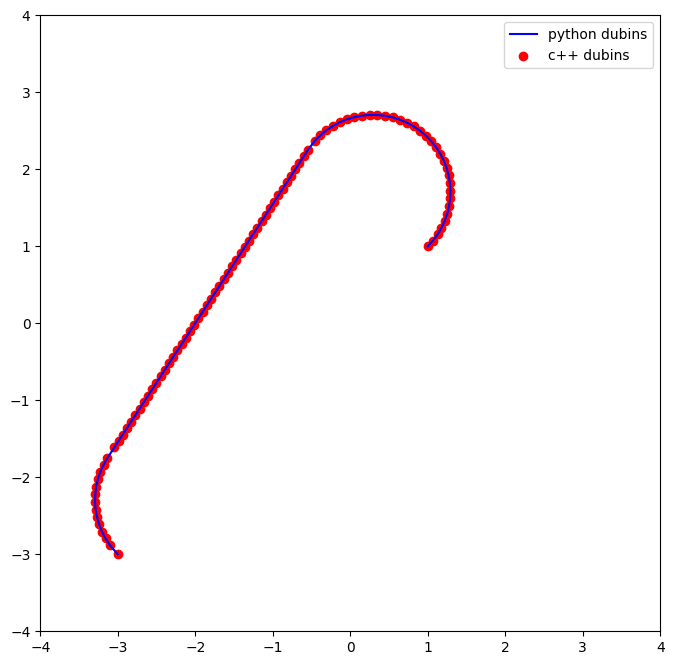

In [20]:
plt.figure(figsize=(8, 8))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.plot(path_x, path_y, color="blue", label='python dubins')
plt.scatter(cpp_path_x, cpp_path_y, color="red", label='c++ dubins')
plt.legend()
plt.show()

In [21]:
def angle_mod(x, zero_2_2pi=False, degree=False):
    if degree:
        x = x * (np.pi / 180.0)

    if zero_2_2pi:
        mod_angle = x % (2.0 * np.pi)
    else:
        mod_angle = (x + np.pi) % (2.0 * np.pi) - np.pi

    if degree:
        mod_angle = mod_angle * (180.0 / np.pi)

    return mod_angle

In [22]:
angle_mod(3.14, True, False)

3.14

In [23]:
angle_mod(-4.71238898, True, False)

1.5707963271795862

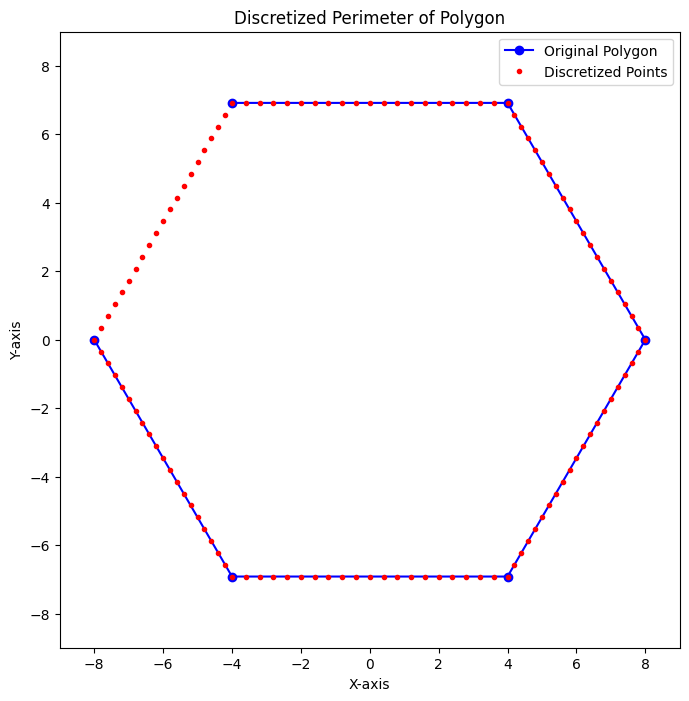

In [24]:
import numpy as np
import matplotlib.pyplot as plt


def discretize_polygon(polygon_vertices, num_points_per_edge):
    points = []

    for i in range(len(polygon_vertices)):
        start_point = polygon_vertices[i]
        # Wrap around for the last edge
        end_point = polygon_vertices[(i + 1) % len(polygon_vertices)]

        x_vals = np.linspace(
            start_point[0], end_point[0], num_points_per_edge, endpoint=False)
        y_vals = np.linspace(
            start_point[1], end_point[1], num_points_per_edge, endpoint=False)

        edge_points = np.column_stack((x_vals, y_vals))
        points.extend(edge_points)

    return np.array(points)


# Example polygon vertices
polygon_vertices = np.array([[-4, 6.92], [4, 6.92], [8, 0], [
                            4, -6.92], [-4, -6.92], [-8, 0]])

# Discretize the perimeter with 100 points per edge
discretized_points = discretize_polygon(
    polygon_vertices, num_points_per_edge=20)

# Plot the original polygon and the discretized points
plt.figure(figsize=(8, 8))
plt.xlim(-9,9)
plt.ylim(-9,9)
plt.plot(polygon_vertices[:, 0], polygon_vertices[:,
         1], 'bo-', label='Original Polygon')
plt.plot(discretized_points[:, 0], discretized_points[:,
         1], 'r.', label='Discretized Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Discretized Perimeter of Polygon')
plt.legend()
plt.show()

In [25]:
discretized_points

array([[-4.   ,  6.92 ],
       [-3.6  ,  6.92 ],
       [-3.2  ,  6.92 ],
       [-2.8  ,  6.92 ],
       [-2.4  ,  6.92 ],
       [-2.   ,  6.92 ],
       [-1.6  ,  6.92 ],
       [-1.2  ,  6.92 ],
       [-0.8  ,  6.92 ],
       [-0.4  ,  6.92 ],
       [ 0.   ,  6.92 ],
       [ 0.4  ,  6.92 ],
       [ 0.8  ,  6.92 ],
       [ 1.2  ,  6.92 ],
       [ 1.6  ,  6.92 ],
       [ 2.   ,  6.92 ],
       [ 2.4  ,  6.92 ],
       [ 2.8  ,  6.92 ],
       [ 3.2  ,  6.92 ],
       [ 3.6  ,  6.92 ],
       [ 4.   ,  6.92 ],
       [ 4.2  ,  6.574],
       [ 4.4  ,  6.228],
       [ 4.6  ,  5.882],
       [ 4.8  ,  5.536],
       [ 5.   ,  5.19 ],
       [ 5.2  ,  4.844],
       [ 5.4  ,  4.498],
       [ 5.6  ,  4.152],
       [ 5.8  ,  3.806],
       [ 6.   ,  3.46 ],
       [ 6.2  ,  3.114],
       [ 6.4  ,  2.768],
       [ 6.6  ,  2.422],
       [ 6.8  ,  2.076],
       [ 7.   ,  1.73 ],
       [ 7.2  ,  1.384],
       [ 7.4  ,  1.038],
       [ 7.6  ,  0.692],
       [ 7.8  ,  0.346],
